In [4]:
from data_load import *
import matplotlib.pyplot as plt

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    SMALL_SIZE = 24
    MEDIUM_SIZE = 24
    BIGGER_SIZE = 24

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    return ax

******** dataset partition summary for ******
train:min-0-max-49, test:min-50-max-99
******** data loaded! ******
(50, 500, 500, 3)
(50, 500, 500)
1.1422166556798545
0.053955706827142624


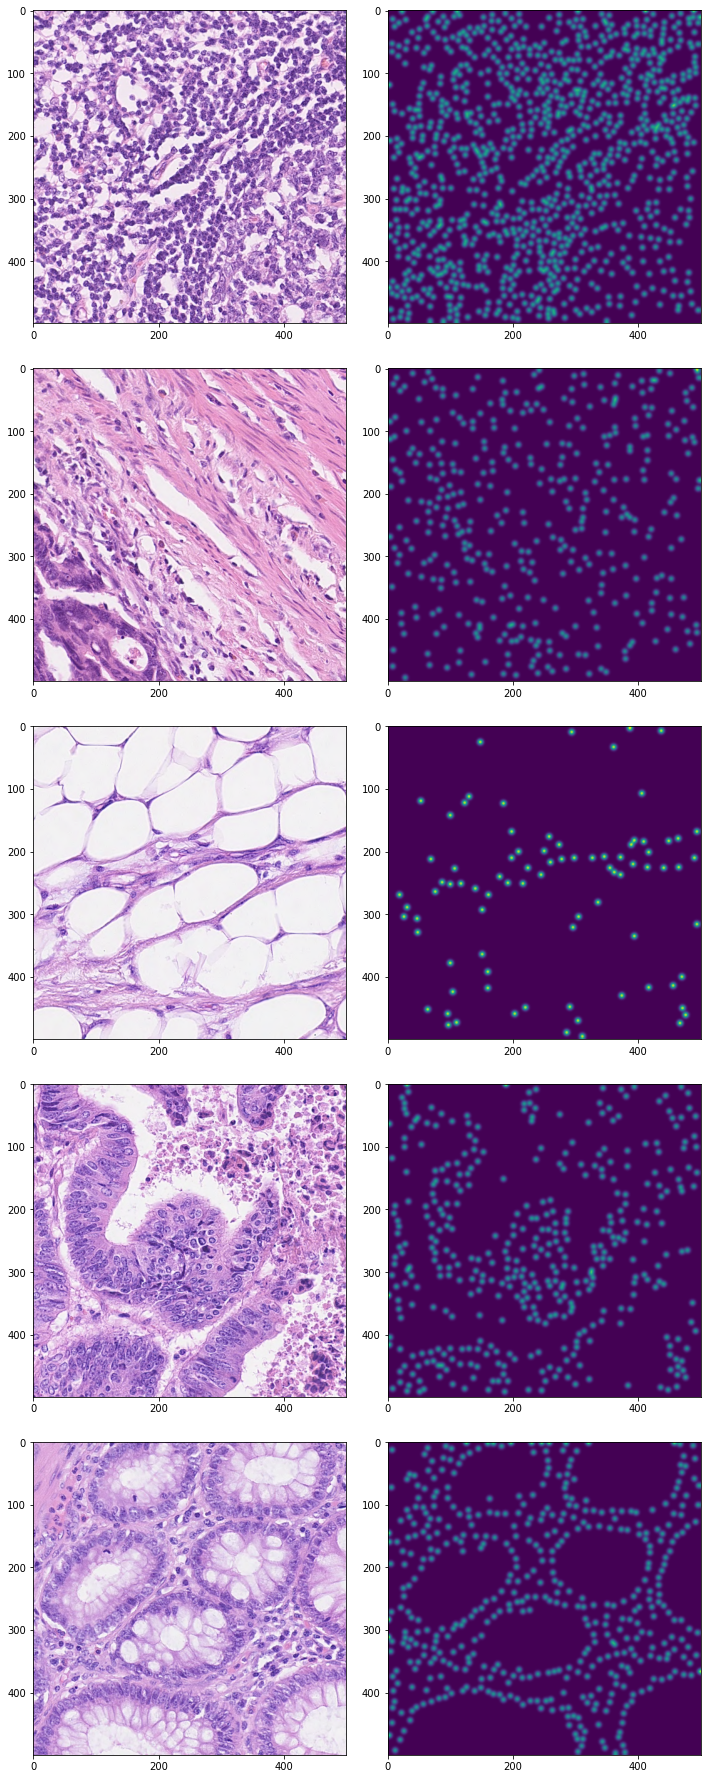

In [3]:
version = 26; cross_val = 0; normal_proc = True
X_train,X_val,Y_train,Y_val = load_train_data(val_version = version, cross_val =cross_val, normal_proc = normal_proc)
print(X_train.shape); print(Y_val.shape)
print(X_train.max()); print(Y_val.max())
nb_images = 5; indices= np.random.randint(0,X_train.shape[0], nb_images);
ax = get_ax(rows=nb_images, cols =2, size = 5)
for i in range(nb_images):
    index = indices[i]
    image = X_train[index,:]; rgb_img = np.uint8(255*(image-image.min())/(image.max()-image.min()))
    ax[i,0].imshow(rgb_img);ax[i,1].imshow(Y_train[index,:])

In [7]:
print(X_train.shape);print(Y_train.shape)

(100, 256, 256, 3)
(100, 256, 256)


In [12]:
import numpy as np
import glob
import os
import re
import csv

from natsort import natsorted
from utils.metrics import *
from utils.file_load_save import *
from utils.plot_function import *
from utils.data_processing import *
from models import *
from data_load import *

import matplotlib.pyplot as plt

# save the figure to png file
def save_plot_figure(fig, file_name, dpi_nb = 100):
    from matplotlib.backends.backend_agg import FigureCanvasAgg
    canvas = FigureCanvasAgg(fig)
    canvas.print_figure(file_name+'.png', dpi=dpi_nb)

Using TensorFlow backend.
/home/sh38/anaconda3/envs/proGAN_tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sh38/anaconda3/envs/proGAN_tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sh38/anaconda3/envs/proGAN_tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sh38/anacon

In [13]:
## parse model name and get
## 5.31/2018
def parse_model_name(model_folder, network_key = 'buildModel', dvkey = 'v-', crosskey = 'cross-'):
	import re
	import os
	x = re.search(dvkey+'\d+', model_folder)
	dat_ver = x.group(0).split('-')[-1]
	dat_ver_int = int(float(dat_ver))
	y = re.search(crosskey+'\d+',model_folder)
	cross_nb = y.group(0).split('-')[-1]
	cross_nb_int = int(float(cross_nb))
	z = re.search(network_key+'\w+', model_folder)
	result_folder_str = os.path.split(model_folder[:z.end()])[1]
	network = z.group(0)
	return network, dat_ver_int, cross_nb_int, result_folder_str

def mean_square_err_for_arr(den_arr, den_arr1):
	from sklearn.metrics import mean_squared_error as MSE
	shp = den_arr.shape
	mse_list = []
	for i in range(shp[0]):
		mse_list.append(MSE(den_arr[i,:].flatten(), den_arr1[i,:].flatten()))
	return np.array(mse_list)

def cosine_for_arr(den_arr, den_arr1):
	cosin_list, _ = density_Cosine_calculate_for_array(den_arr, den_arr1)
	return np.array(cosin_list)

def cosine_calculate(den, den1):
	return density_Cosine_calculate(den, den1)

# the co-registration between the gt_arr and est_arr
def coregistr_gt_est(gt_arr, est_arr):
	if len(gt_arr.shape) == 2:
		gt_arr = gt_arr.reshape((1,)+gt_arr.shape)
		est_arr = est_arr.reshape((1,)+est_arr.shape)
	shp = gt_arr.shape
	est_shp = est_arr.shape
	co_est = np.zeros(shp)
	h_dif = abs(shp[1] - est_shp[1])
	w_dif = abs(shp[2] - est_shp[2])
	co_est = est_arr[:,int(h_dif/2):est_shp[1]-int(h_dif/2),int(w_dif/2):est_shp[2]-int(w_dif/2)]
	co_est = np.squeeze(co_est)
	return co_est

In [77]:
	cross = 5
	# results_root_folder = os.path.expanduser('~/dl-cells/dlct-framework/results/MIA2018_v1_6.6-7.6')
	# results_root_folder = os.path.expanduser('~/dl-cells/dlct-framework/results/MIA2018_v3_6.6-7.6')  ## Jun 27.2019
	results_root_folder = os.path.expanduser('/shared/planck/Cellcounting/turing/shenghua/dl-cells/dlct-framework/results/MIA2018_v3_6.6-7.6')  ## Jun 27.2019
	result_folders = []
	results_ptrn = os.path.join(results_root_folder, 'build*')
	result_folders = glob.glob(results_ptrn)
	image_for_methods = []
	gt_for_methods = []
	est_for_methods = []
	std_for_methods = []
	runtime_for_methods = []
	mae_for_methods = []
	mre_for_methods = []   ## for MIA Journal 2020
	mre_std_for_methods = []   ## for MIA Journal 2020
	mean_mse_for_methods = []
	mcosine_for_methods = []
	m_ace_for_methods = []
	std_ace_for_methods = []
	crossmre_for_methods = []       ## the average over 5-fold cross validation
	crossmre_std_for_methods = []   ## the average over 5-fold cross validation
	method_pool = []

In [30]:
print(result_folders)

['/shared/planck/Cellcounting/turing/shenghua/dl-cells/dlct-framework/results/MIA2018_v3_6.6-7.6/buildMultiModel_U_net', '/shared/planck/Cellcounting/turing/shenghua/dl-cells/dlct-framework/results/MIA2018_v3_6.6-7.6/buildModel_U_net']


In [78]:
	for result_folder in result_folders:
		print(os.path.basename(result_folder))
# 		result_folder = result_folders[3]
		result_version_ptrn = os.path.join(result_folder,'data_version-*')
		result_version_folders = glob.glob(result_version_ptrn)
		result_version_folders = natsorted(result_version_folders)
		method_pool.append(os.path.basename(result_folder))
		# data pool
		image_pool = []   # data from different methods
		gt_pool = []
		est_pool = []
		# metrics pool
		abs_err_pool = []
		re_err_pool = []
		cosine_pool = []
		mse_pool = []
		runtime_pool = []
		ave_err_pool = []
		ave_re_pool = []
		for result_version in result_version_folders:
# 			result_version = result_version_folders[0]
			if cross == 0:
				result_cross_folders = glob.glob(os.path.join(result_version, 'cross-{}'.format(cross)))
			else:
				result_cross_folders = glob.glob(os.path.join(result_version, 'cross*'));result_cross_folders=natsorted(result_cross_folders)
# 				print(result_cross_folders)
			### for each type of cells
			# data: image, ground truth map, and estimated density map
			image_list = []
			gt_list = []
			est_list = []
			runtime_list = []
			ave_re_list = []
			# metrics of performance
			# divide
			## after June 14, 2019, use the average count errors as the primary metrics to measure 
			## the counting accuracy, and the standard deviation of the average count errors across 
			## different folds of data to measure the variance of the average count error, which is different from 
			## the previous standard deviation metric that measures the variance of cell count error directly
			ace_list = []  ## the list of average count error in each fold
			for result_cross in result_cross_folders:
	# 				result_cross = result_cross_folders[0]
				result_pkl_ptrn = os.path.join(result_cross,'*.pkl')
				pkl_files = glob.glob(result_pkl_ptrn); pkl_files=natsorted(pkl_files)#print(pkl_files[0])
				cross_est_list = []
				cross_gt_list = []
				for pkl_file in pkl_files:
					results = read_any_pickle(pkl_file, keys = ['est_den', 'gt_den', 'ori_img', 'run_time'])
					est_list.append(results[0])
					gt_list.append(results[1])
					image_list.append(results[2])
					runtime_list.append(results[3])
					cross_est_list.append(results[0])
					cross_gt_list.append(results[1])
				## calculate average count error in each fold
				cr_est_arr = np.array(cross_est_list)
				cr_gt_arr = np.array(cross_gt_list)
				cr_est_arr = coregistr_gt_est(cr_gt_arr, cr_est_arr)
				cr_gt_count_arr = np.squeeze(np.apply_over_axes(np.sum, cr_gt_arr, [1,2]))
				cr_est_count_arr = np.squeeze(np.apply_over_axes(np.sum, cr_est_arr, [1,2]))
				cr_count_err_arr = np.abs(cr_est_count_arr-cr_gt_count_arr)
				cr_count_re_arr = np.abs(cr_est_count_arr-cr_gt_count_arr)/cr_gt_count_arr
				ace_list.append(np.mean(cr_count_err_arr))
				ave_re_list.append(np.mean(cr_count_re_arr))
# 				print(cr_count_re_arr.shape[0])

			image_arr = np.array(image_list)
			gt_arr = np.array(gt_list)
			est_arr = np.array(est_list)
# 			print(est_arr.shape)
			est_arr = coregistr_gt_est(gt_arr, est_arr)
# 			print(est_arr.shape)
			runtime_arr = np.array(runtime_list)
			image_arr = coregistr_gt_est(gt_arr, image_arr)
			# analyze the results for each type of cells
			mse_arr = mean_square_err_for_arr(gt_arr,est_arr)
			cosin_arr = cosine_for_arr(gt_arr, est_arr)
			gt_count_arr = np.squeeze(np.apply_over_axes(np.sum, gt_arr, [1,2]))
			est_count_arr = np.squeeze(np.apply_over_axes(np.sum, est_arr, [1,2]))
			abs_err_arr = np.abs(gt_count_arr-est_count_arr)
			re_err_err = np.abs(gt_count_arr-est_count_arr)/gt_count_arr
			print(np.mean(abs_err_arr))
		
			## data merge
			image_pool.append(image_arr)
			gt_pool.append(gt_arr)
			est_pool.append(est_arr)
			runtime_pool.append(runtime_arr)
# 			print('run time number:{0:}'.format(runtime_arr.shape))

			## metrics
			abs_err_pool.append(abs_err_arr)
			re_err_pool.append(re_err_err)
			mse_pool.append(mse_arr)
			cosine_pool.append(cosin_arr)
			ave_err_pool.append(ace_list)
			ave_re_pool.append(ave_re_list)
		## compute the total average
		mae_pool = []
		std_pool = []
		mre_pool = []
		mre_std_pool = []
		mcosine_pool = []
		mean_mse_pool = []
		mean_runtime_pool = []
		for abs_arr in abs_err_pool:
			mae_pool.append(round(np.mean(abs_arr),5))
# 			print(np.mean(abs_arr))
# 			print(abs_arr.shape[0])
		for abs_arr in abs_err_pool:
			std_pool.append(round(np.std(abs_arr),5))
		for re_arr in re_err_pool:
			mre_pool.append(round(np.mean(re_arr),5))
			mre_std_pool.append(round(np.std(re_arr),5))
		for cosine_arr in cosine_pool:
			mcosine_pool.append(round(np.mean(cosine_arr),5))
		for mse_arr in mse_pool:
			mean_mse_pool.append(np.mean(mse_arr))
		for runtime_arr in runtime_pool:
			mean_runtime_pool.append(round(np.mean(runtime_arr),5))
		
		## calculate the mean of average count error and its standard deviation
		m_ave_err_pool = []
		std_ave_err_pool = []
		for ave_err in ave_err_pool:
			m_ave_err_pool.append(round(np.mean(ave_err),5))
			std_ave_err_pool.append(round(np.std(ave_err),5))


		## for relative error
		m_ave_re_pool = []
		std_ave_re_pool = []
		for ave_re in ave_re_pool:
			m_ave_re_pool.append(round(np.mean(ave_re),5))
			std_ave_re_pool.append(round(np.std(ave_re),5))

# 		total_abs_arr = np.concatenate(abs_err_pool)
# 		total_re_arr = np.concatenate(re_err_pool)
# 		total_cosine_arr = np.concatenate(cosine_pool)
# 		total_mse_arr = np.concatenate(mse_pool)
# 		average_mae = np.mean(total_abs_arr)
# 		average_re = np.mean(total_re_arr)
# 		average_cosine = np.mean(total_cosine_arr)
# 		average_mse = np.mean(total_mse_arr)
# 	
# 		# add average to each metric list: 31,32,33,34,35, average
# 		if len(result_version_folders)>1:
# 			mae_pool.append(average_mae)
# 			mre_pool.append(average_re)
# 			mcosine_pool.append(average_cosine)
# 			mean_mse_pool.append(average_mse)

		mae_for_methods.append(mae_pool)
		std_for_methods.append(std_pool)
		mre_for_methods.append(mre_pool)
		mre_std_for_methods.append(mre_std_pool)
		mcosine_for_methods.append(mcosine_pool)
		mean_mse_for_methods.append(mean_mse_pool)
		runtime_for_methods.append(mean_runtime_pool)
		m_ace_for_methods.append(m_ave_err_pool)  		# average count error
		std_ace_for_methods.append(std_ave_err_pool) 	# standard deviation of average count errors
		crossmre_for_methods.append(m_ave_re_pool)  		# average relative count error
		crossmre_std_for_methods.append(std_ave_re_pool) 	# standard deviation of relative count error

		# store the testing data
		image_for_methods.append(image_pool)
		gt_for_methods.append(gt_pool)
		est_for_methods.append(est_pool)

buildMultiModel_U_net
2.375139122009276
6.548373428503281
29.343708311319343
32.890648355289386
buildModel_FCRN_A
2.7519287109374977
8.460639779298228
40.56052231073379
44.904208747708076
buildModel_U_net
2.5830982971191405
8.684737205235988
39.557400121688836
42.17407693668287
buildModel_Count_ception
2.787429008483887
7.8926714897155765
34.143050343990325
35.867994658801024


In [39]:
print(pkl_files)

['/shared/planck/Cellcounting/turing/shenghua/dl-cells/dlct-framework/results/MIA2018_v3_6.6-7.6/buildModel_U_net/data_version-27/cross-5/0.pkl', '/shared/planck/Cellcounting/turing/shenghua/dl-cells/dlct-framework/results/MIA2018_v3_6.6-7.6/buildModel_U_net/data_version-27/cross-5/1.pkl', '/shared/planck/Cellcounting/turing/shenghua/dl-cells/dlct-framework/results/MIA2018_v3_6.6-7.6/buildModel_U_net/data_version-27/cross-5/2.pkl', '/shared/planck/Cellcounting/turing/shenghua/dl-cells/dlct-framework/results/MIA2018_v3_6.6-7.6/buildModel_U_net/data_version-27/cross-5/3.pkl', '/shared/planck/Cellcounting/turing/shenghua/dl-cells/dlct-framework/results/MIA2018_v3_6.6-7.6/buildModel_U_net/data_version-27/cross-5/4.pkl', '/shared/planck/Cellcounting/turing/shenghua/dl-cells/dlct-framework/results/MIA2018_v3_6.6-7.6/buildModel_U_net/data_version-27/cross-5/5.pkl', '/shared/planck/Cellcounting/turing/shenghua/dl-cells/dlct-framework/results/MIA2018_v3_6.6-7.6/buildModel_U_net/data_version-27/

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
0.0
(200, 256, 256)
(200, 256, 256)


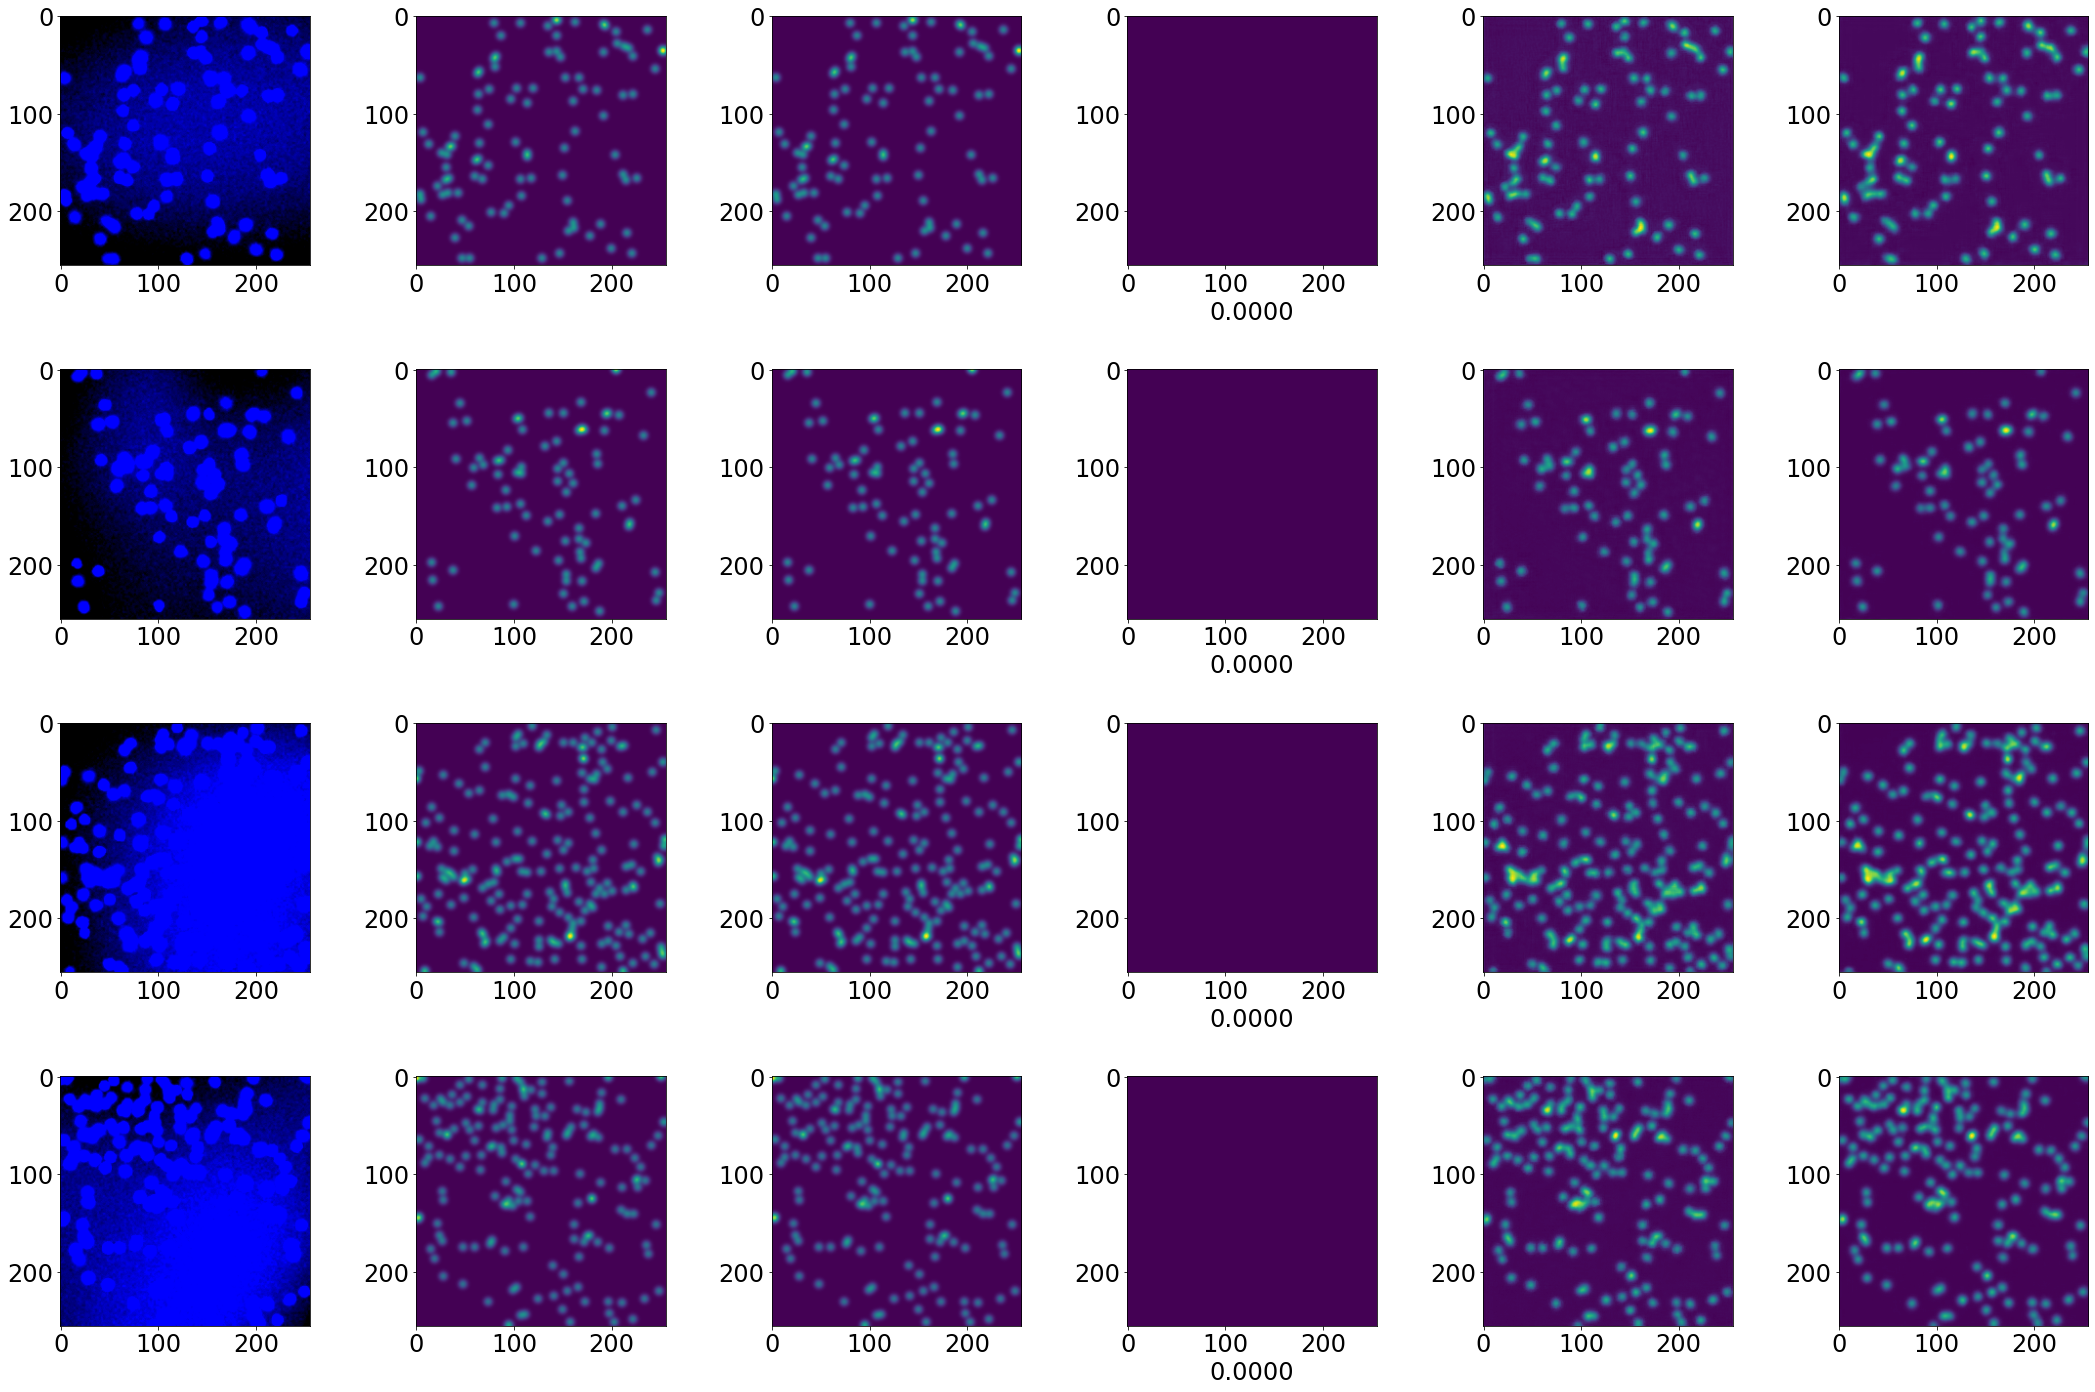

In [79]:
## compare the statisitcally significance of difference between the C-FCRN+AuxCNN and C-FCRN
## check the consistency between the two results
dataset_index = 0; method_index = 1
images = image_for_methods[0][dataset_index];
gt_maps = gt_for_methods[0][dataset_index]; gt_maps1 = gt_for_methods[method_index][dataset_index];
est_maps = est_for_methods[0][dataset_index]; est_maps1 = est_for_methods[method_index][dataset_index];
indices = np.random.randint(0,gt_maps.shape[0],4)
ax = get_ax(4,6,5)
for i in range(len(indices)):
    index=indices[i]; image=images[index,:]; print(image.shape)
    diff = np.abs(gt_maps[index,:].squeeze()-gt_maps1[index,:].squeeze())
    est = est_maps[index,:].squeeze(); est1 = est_maps1[index,].squeeze()
    ax[i,0].imshow(image); ax[i,1].imshow(gt_maps[index,:].squeeze());ax[i,2].imshow(gt_maps1[index,:])
    ax[i,3].imshow(diff); ax[i,3].set_xlabel('{:.4f}'.format(np.sum(diff)))
    ax[i,4].imshow(est);ax[i,5].imshow(est1)
print(np.sum(np.abs(gt_maps-gt_maps1)))
print(est_for_methods[0][dataset_index].shape)
print(est_for_methods[1][dataset_index].shape)

In [113]:
## compare the statisitcally significance of difference between the C-FCRN+AuxCNN and C-FCRN
## compute the err difference
dataset_index = 1; method_index = 2
gt_maps = gt_for_methods[0][dataset_index]; gt_maps1 = gt_for_methods[method_index][dataset_index];
est_maps = est_for_methods[0][dataset_index]; est_maps1 = est_for_methods[method_index][dataset_index];
# err_maps = np.abs(gt_maps-est_maps); err_maps1 = np.abs(gt_maps1-est_maps1)
# print(err_maps.shape);print(err_maps1.shape)
# count err along images
errs = np.abs(gt_maps.sum(axis=(1,2))-est_maps.sum(axis=(1,2)))
errs1 = np.abs(gt_maps1.sum(axis=(1,2))-est_maps1.sum(axis=(1,2)))
print(errs.mean());print(errs1.mean())
## H0: A>=B, H1: A<B
A = errs; B= errs1
#t1,p1 = stats.ttest_ind(B,A); print(t1,p1)
t2, p2= stats.ttest_rel(B,A); print('t-test:{:.4f} p-value:{:.4f}'.format(t2,p2))

6.5483740007078755
8.684737205235988
t-test:2.3538 p-value:0.0237


In [103]:
from scipy import stats

In [125]:
## compare the statisitcally significance of difference between the C-FCRN+AuxCNN and C-FCRN
## compute the err difference
# dataset_index = 1; method_index = 2
p_mat = np.zeros((3,4)); t_mat = np.zeros((3,4))
for method_index in range(1,4):
#     print(method_index)
    for dataset_index in range(4):
        print(os.path.basename(result_folders[method_index]))
        gt_maps = gt_for_methods[0][dataset_index]; gt_maps1 = gt_for_methods[method_index][dataset_index];
        est_maps = est_for_methods[0][dataset_index]; est_maps1 = est_for_methods[method_index][dataset_index];
        # err_maps = np.abs(gt_maps-est_maps); err_maps1 = np.abs(gt_maps1-est_maps1)
        # print(err_maps.shape);print(err_maps1.shape)
        # count err along images
        errs = np.abs(gt_maps.sum(axis=(1,2))-est_maps.sum(axis=(1,2)))
        errs1 = np.abs(gt_maps1.sum(axis=(1,2))-est_maps1.sum(axis=(1,2)))
        print(errs.mean());print(errs1.mean())
        ## H0: A>=B, H1: A<B
        A = errs; B= errs1
        #t1,p1 = stats.ttest_ind(B,A); print(t1,p1)
        t2, p2= stats.ttest_rel(B,A); print('t-test:{:.4f} p-value:{:.4f}'.format(t2,p2))
        p_mat[method_index-1,dataset_index] =p2;t_mat[method_index-1,dataset_index] =t2;

## print out the performance
print('P-value')
for i in range(3):
    print('{:.6f},{:.6f},{:.6f},{:.6f}'.format(p_mat[i,0], p_mat[i,1], p_mat[i,2], p_mat[i,3]))

print('T-test')
for i in range(3):
    print('{:.6f},{:.6f},{:.6f},{:.6f}'.format(t_mat[i,0], t_mat[i,1], t_mat[i,2], t_mat[i,3]))

buildModel_FCRN_A
2.375137786865231
2.751927299499508
t-test:3.2770 p-value:0.0012
buildModel_FCRN_A
6.5483740007078755
8.46063815805189
t-test:1.7755 p-value:0.0836
buildModel_FCRN_A
29.343705819845198
40.56052624046802
t-test:5.1236 p-value:0.0000
buildModel_FCRN_A
32.89066081144371
44.90420905911194
t-test:2.9024 p-value:0.0056
buildModel_U_net
2.375137786865231
2.5830973052978488
t-test:1.9071 p-value:0.0579
buildModel_U_net
6.5483740007078755
8.684737205235988
t-test:2.3538 p-value:0.0237
buildModel_U_net
29.343705819845198
39.557402056455615
t-test:3.9495 p-value:0.0001
buildModel_U_net
32.89066081144371
42.174078493702176
t-test:2.1913 p-value:0.0333
buildModel_Count_ception
2.375137786865231
2.7874301147460936
t-test:1.9876 p-value:0.0482
buildModel_Count_ception
6.5483740007078755
7.892671966552735
t-test:1.2979 p-value:0.2019
buildModel_Count_ception
29.343705819845198
34.14305521885865
t-test:2.2458 p-value:0.0269
buildModel_Count_ception
32.89066081144371
35.8679828254544
t